In [1]:
from datetime import datetime
import os
os.chdir('..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import reference, subject, acquisition, stimulation, analysis #, behavior, ephys, action

Connecting root@127.0.0.1:3306


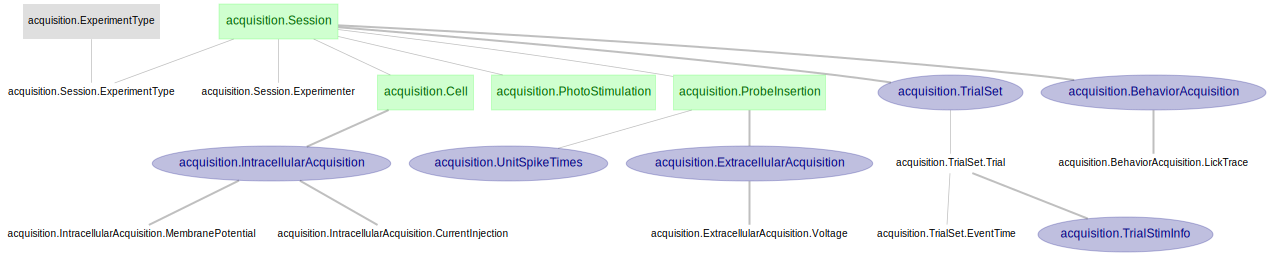

In [30]:
dj.ERD(acquisition)

## Reproduce Figure 4b, e, h - Whole cell

In [2]:
# -- get all whole cell
cell_keys = acquisition.Cell.fetch(dj.key)

In [3]:
# -- backtrack session, and get photostim info
# photostim keys for contra ALM stimulation
region_dict = {'brain_region':'ALM', 'hemisphere':'right'}
contraALM_photostims = (acquisition.PhotoStimulation & cell_keys & region_dict).fetch(dj.key)
# photostim keys for thalamus stimulation
region_dict = {'brain_region':'VM', 'hemisphere':'left'}
thal_photostims = (acquisition.PhotoStimulation & cell_keys & region_dict).fetch(dj.key)
# photostim keys for M1 stimulation
region_dict = {'brain_region':'M1', 'hemisphere':'left'}
m1_photostims = (acquisition.PhotoStimulation & cell_keys & region_dict).fetch(dj.key)

In [4]:
# -- define cell restrictor for each stim location
contraALM_stim_cells = (acquisition.Cell & contraALM_photostims).fetch(dj.key)
thal_stim_cells = (acquisition.Cell & thal_photostims).fetch(dj.key)
m1_stim_cells = (acquisition.Cell & m1_photostims).fetch(dj.key)

In [5]:
# define some trial restrictor 
stim_trial_cond = {'trial_is_good': True, 'trial_stim_present': True}
nostim_trial_cond = {'trial_is_good': True, 'trial_stim_present': False}

In [6]:
# define trial-segmentation setting 
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'pole_out', 'pre_stim_duration': 1.5, 'post_stim_duration': 3}).fetch1(dj.key)

In [7]:
def query_segmented_intracellular_data(cell_key, trial_key, seg_param_key):
    data_keys = (analysis.TrialSegmentedIntracellular & cell_key & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key))
    data = []
    for k in data_keys:
        segmented_mp, segmented_mp_wo_spike = (analysis.TrialSegmentedIntracellular.MembranePotential & k).fetch1('segmented_mp', 'segmented_mp_wo_spike') 
        realigned_trial_event, realigned_event_time = (analysis.RealignedEvent.RealignedEventTime & k).fetch('realigned_trial_event','realigned_event_time')
        data.append({
                **dict(zip(['segmented_mp', 'segmented_mp_wo_spike'], [segmented_mp, segmented_mp_wo_spike])), 
                **dict(zip(realigned_trial_event,realigned_event_time)) }) 
    return data

In [8]:
# query trial-segmented data based on the cell and trial restrictors    
contraALM_stim_trial_data = query_segmented_intracellular_data(contraALM_stim_cells, stim_trial_cond, seg_param_key)
contraALM_nostim_trial_data = query_segmented_intracellular_data(contraALM_stim_cells, nostim_trial_cond, seg_param_key)

thal_stim_trial_data = query_segmented_intracellular_data(thal_stim_cells, stim_trial_cond, seg_param_key)
thal_nostim_trial_data = query_segmented_intracellular_data(thal_stim_cells, nostim_trial_cond, seg_param_key)

m1_stim_trial_data = query_segmented_intracellular_data(m1_stim_cells, stim_trial_cond, seg_param_key)
m1_nostim_trial_data = query_segmented_intracellular_data(m1_stim_cells, nostim_trial_cond, seg_param_key)

In [9]:
# get sampling rate
fs = acquisition.IntracellularAcquisition.MembranePotential.fetch('membrane_potential_sampling_rate', limit=1)

In [10]:
# 
data_point_count = (np.array([k['segmented_mp_wo_spike'].size for k in contraALM_stim_trial_data])).min().astype(int)
contraALM_stim_mp = {'sample_num': data_point_count,
                     'data': np.vstack([ k['segmented_mp_wo_spike'][0:data_point_count] for k in contraALM_stim_trial_data]),
                     'timestamps': np.arange(data_point_count) / fs - float(seg_param_key['pre_stim_duration'])}
data_point_count = (np.array([k['segmented_mp_wo_spike'].size for k in contraALM_nostim_trial_data])).min().astype(int)
contraALM_nostim_mp = {'sample_num': data_point_count,
                     'data': np.vstack([ k['segmented_mp_wo_spike'][0:data_point_count] for k in contraALM_nostim_trial_data]),
                     'timestamps': np.arange(data_point_count) / fs - float(seg_param_key['pre_stim_duration'])}

data_point_count = (np.array([k['segmented_mp_wo_spike'].size for k in thal_stim_trial_data])).min().astype(int)
thal_stim_mp = {'sample_num': data_point_count,
                     'data': np.vstack([ k['segmented_mp_wo_spike'][0:data_point_count] for k in thal_stim_trial_data]),
                     'timestamps': np.arange(data_point_count) / fs - float(seg_param_key['pre_stim_duration'])}
data_point_count = (np.array([k['segmented_mp_wo_spike'].size for k in thal_nostim_trial_data])).min().astype(int)
thal_nostim_mp = {'sample_num': data_point_count,
                     'data': np.vstack([ k['segmented_mp_wo_spike'][0:data_point_count] for k in thal_nostim_trial_data]),
                     'timestamps': np.arange(data_point_count) / fs - float(seg_param_key['pre_stim_duration'])}

data_point_count = (np.array([k['segmented_mp_wo_spike'].size for k in m1_stim_trial_data])).min().astype(int)
m1_stim_mp = {'sample_num': data_point_count,
                     'data': np.vstack([ k['segmented_mp_wo_spike'][0:data_point_count] for k in m1_stim_trial_data]),
                     'timestamps': np.arange(data_point_count) / fs - float(seg_param_key['pre_stim_duration'])}
data_point_count = (np.array([k['segmented_mp_wo_spike'].size for k in m1_nostim_trial_data])).min().astype(int)
m1_nostim_mp = {'sample_num': data_point_count,
                     'data': np.vstack([ k['segmented_mp_wo_spike'][0:data_point_count] for k in m1_nostim_trial_data]),
                     'timestamps': np.arange(data_point_count) / fs - float(seg_param_key['pre_stim_duration'])}

In [11]:
def plot_with_sem(data1, data2, ax):
    v_mean = data1['data'].mean(axis=0)
    v_sem = data1['data'].std(axis=0) / np.sqrt(data1['data'].shape[0])
    ax.plot(data1['timestamps'], v_mean,'b')
    ax.fill_between(data1['timestamps'], v_mean - v_sem, v_mean + v_sem, alpha=0.5, facecolor='b')
    
    v_mean = data2['data'].mean(axis=0)
    v_sem = data2['data'].std(axis=0) / np.sqrt(data2['data'].shape[0])
    ax.plot(data2['timestamps'], v_mean,'k')
    ax.fill_between(data2['timestamps'], v_mean - v_sem, v_mean + v_sem,  alpha=0.5, facecolor='gray')
    
    ax.axvline(x=0, linestyle='--', color='k')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

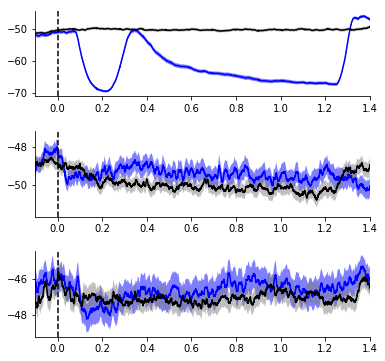

In [12]:
# plot
fig4 = plt.figure(figsize=(6, 6))
fig4.subplots_adjust(hspace=0.4)

ax_b = fig4.add_subplot(311)
plot_with_sem(thal_stim_mp, thal_nostim_mp, ax_b)
ax_b.set_xlim(-0.1, 1.4);

ax_e = fig4.add_subplot(312)
plot_with_sem(m1_stim_mp, m1_nostim_mp, ax_e)
ax_e.set_xlim(-0.1, 1.4);

ax_h = fig4.add_subplot(313)
plot_with_sem(contraALM_stim_mp, contraALM_nostim_mp, ax_h)
ax_h.set_xlim(-0.1, 1.4);

## Reproduce Figure 3b, 6b - Extracellular

In [13]:
# get trial-segmented spiketimes for a single unit in the one specifed session
def query_unit_segmented_spiketimes(sess_key, unit, trial_key, seg_param_key):
    data_keys = (analysis.TrialSegmentedUnitSpikeTimes & sess_key & {'unit_id': unit} & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key)).fetch(dj.key)
    data = []
    for k in data_keys:
        segmented_spike_times = (analysis.TrialSegmentedUnitSpikeTimes & k).fetch1('segmented_spike_times') 
        realigned_trial_event, realigned_event_time = (analysis.RealignedEvent.RealignedEventTime & k).fetch('realigned_trial_event','realigned_event_time')
        data.append({
                **{'segmented_spike_times': segmented_spike_times}, 
                **dict(zip(realigned_trial_event, realigned_event_time))}) 
    return pd.DataFrame(data)

In [14]:
# def in1d_with_tolerance_v2(A, B, tol=1e-03):
#     S = round(1/tol)
#     return np.in1d(np.around(A * S).astype(int),np.around(B * S).astype(int))

In [15]:
def plot_spike_raster_and_histogram(contra_spike_times, ipsi_spike_times, axes, ax_title='', bin_counts=200):
    # get event timing
    events = ['pole_in', 'pole_out', 'cue_start']
    event_times = np.around([np.hstack([ipsi_spike_times[e], contra_spike_times[e]]).mean() for e in events], 4)
    
    # restructure data for spike raster
    ipsi_c_trial_idx, ipsi_c_spike_times = [], []
    r_i = 0
    for r in ipsi_spike_times.segmented_spike_times:
        if len(r) == 0:
            continue
        r_i += 1
        ipsi_c_spike_times.append(r)
        ipsi_c_trial_idx.append(np.full_like(r, r_i))
    ipsi_c_trial_idx = np.hstack(ipsi_c_trial_idx)
    ipsi_c_spike_times = np.hstack(ipsi_c_spike_times)
    
    contra_c_trial_idx, contra_c_spike_times = [], []
    r_i = 0
    for r in contra_spike_times.segmented_spike_times:
        if len(r) == 0:
            continue
        r_i += 1
        contra_c_spike_times.append(r)
        contra_c_trial_idx.append(np.full_like(r, r_i))
    contra_c_trial_idx = np.hstack(contra_c_trial_idx)
    contra_c_spike_times = np.hstack(contra_c_spike_times)
    
    # spiketime histogram
    time_range = (np.hstack([ipsi_spike_times.trial_start, contra_spike_times.trial_start]).min(),
                  np.hstack([ipsi_spike_times.trial_stop, contra_spike_times.trial_stop]).max())

    ipsi_spk_counts, ipsi_edges = np.histogram(np.hstack([r for r in ipsi_spike_times.segmented_spike_times]),
                                       bins=bin_counts,
                                       range=(time_range[0], time_range[-1]))
    ipsi_spk_rates = ipsi_spk_counts / np.diff(ipsi_edges) / ipsi_spike_times.segmented_spike_times.shape[0]
    
    contra_spk_counts, contra_edges = np.histogram(np.hstack([r for r in contra_spike_times.segmented_spike_times]),
                                       bins=bin_counts,
                                       range=(time_range[0], time_range[-1]))
    contra_spk_rates = contra_spk_counts / np.diff(contra_edges) / contra_spike_times.segmented_spike_times.shape[0]
   
    # plot
    # spike raster
    ax_top = axes[0]
    ax_top.plot(contra_c_spike_times, contra_c_trial_idx + ipsi_c_trial_idx.max(), '|r')
    ax_top.plot(ipsi_c_spike_times, ipsi_c_trial_idx, '|b')
    # event markers
    for e in event_times:
        ax_top.axvline(x=e, linestyle='--', color='k')
    ax_top.set_xticklabels([])
    ax_top.set_yticklabels([])
    ax_top.set_ylabel(ax_title)
    ax_top.set_xlim(-1.5, 3);
    
    # spike histogram
    ax_bot = axes[1]
    ax_bot.plot(ipsi_edges[1:], ipsi_spk_rates, 'b')
    ax_bot.plot(contra_edges[1:], contra_spk_rates, 'r')
    for e in event_times:
        ax_bot.axvline(x=e, linestyle='--', color='k')
    ax_bot.set_xlim(-1.5, 3);
    
    # Hide the spines
    ax_top.spines['right'].set_visible(False)
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['left'].set_visible(False)
    ax_top.spines['bottom'].set_visible(False)
    ax_bot.spines['right'].set_visible(False)
    ax_bot.spines['top'].set_visible(False)

In [16]:
# blue - correct contra trial (licking-right) ; red - correct ipsi trial (licking left)
correct_contra_trial_stim =  {'trial_is_good': True, 'trial_stim_present': True, 'trial_type': 'lick right'}
correct_ipsi_trial_stim =  {'trial_is_good': True, 'trial_stim_present': True, 'trial_type': 'lick left'}
correct_contra_trial_ctrl =  {'trial_is_good': True, 'trial_stim_present': False, 'trial_type': 'lick right'}
correct_ipsi_trial_ctrl =  {'trial_is_good': True, 'trial_stim_present': False, 'trial_type': 'lick left'}

ec_alm_insert = (acquisition.ProbeInsertion & {'brain_region': 'ALM', 'hemisphere': 'left'})
ec_thal_insert = (acquisition.ProbeInsertion & {'brain_region': 'thalamus', 'hemisphere': 'left'})

alm_photostim = (acquisition.PhotoStimulation & {'brain_region': 'ALM', 'hemisphere': 'left'})
thal_photostim = (acquisition.PhotoStimulation & {'brain_region': 'thalamus', 'hemisphere': 'left'})

# ALM probe with ALM or Thalamus photostim
alm_insert_alm_stim = (acquisition.Session & ec_alm_insert) & (acquisition.Session & alm_photostim).fetch('KEY')
alm_insert_thal_stim = (acquisition.Session & ec_alm_insert) & (acquisition.Session & thal_photostim).fetch('KEY')
# Thalamus probe with ALM or Thalamus photostim
thal_insert_alm_stim = (acquisition.Session & ec_thal_insert) & (acquisition.Session & alm_photostim).fetch('KEY')
thal_insert_thal_stim = (acquisition.Session & ec_thal_insert) & (acquisition.Session & thal_photostim).fetch('KEY')

In [17]:
(acquisition.UnitSpikeTimes & alm_insert_alm_stim)
(acquisition.UnitSpikeTimes & alm_insert_thal_stim)
(acquisition.UnitSpikeTimes & thal_insert_alm_stim)
(acquisition.UnitSpikeTimes & thal_insert_thal_stim)

subject_id id of the subject (e.g. ANM244028),session_time session time,probe_name String naming probe model,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,coordinate_ref,"coordinate_ap in mm, anterior positive, posterior negative","coordinate_ml in mm, always postive, number larger when more lateral","coordinate_dv in mm, always postive, number larger when more ventral (deeper)",unit_id,channel_id id of a channel on the probe,"spike_times (s) time of each spike, with respect to the start of session","unit_cell_type e.g. cell-type of this unit (e.g. wide width, narrow width spiking)",unit_x (mm),unit_y (mm),unit_z (mm),spike_waveform waveform(s) of each spike at each spike time (spike_time x waveform_timestamps)
anm00313106,2017-06-27 09:41:48,ADunit,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,1,0,=BLOB=,Wide width spiking,1.3,-3.88,-1.5,=BLOB=
anm00313106,2017-06-27 09:41:48,ADunit,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,2,1,=BLOB=,Wide width spiking,1.32436,-3.78301,-1.5,=BLOB=
anm00313106,2017-06-27 09:41:48,ADunit,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,3,1,=BLOB=,Wide width spiking,1.32436,-3.78301,-1.5,=BLOB=
anm00313106,2017-06-27 09:41:48,ADunit,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,4,7,=BLOB=,Wide width spiking,1.47053,-3.20109,-1.5,=BLOB=
anm00313106,2017-06-27 09:41:48,ADunit,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,5,9,=BLOB=,Wide width spiking,1.51834,-3.83174,-1.5,=BLOB=
anm00313106,2017-06-27 09:41:48,ADunit,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,6,13,=BLOB=,Wide width spiking,1.61578,-3.44379,-1.5,=BLOB=
anm00313106,2017-06-27 09:41:48,ADunit,Thalamus,N/A,N/A,left,bregma,2.50,-1.50,0.00,7,25,=BLOB=,Wide width spiking,1.90628,-3.92918,-1.5,=BLOB=


# Example unit - Fig 3b & 6b

In [18]:
# # Chery-picking unit and session...
# for idx, sess in enumerate(alm_insert_thal_stim.fetch('KEY')): # pick one session here
#     print([idx, len(acquisition.TrialSet.Trial & sess & correct_contra_trial_stim),
#            len(acquisition.TrialSet.Trial & sess & correct_ipsi_trial_stim)])

In [19]:
# get segmented spike times for one unit - ALM-insert, thal-stim
def make_unit_spiketimes(unit, sess):
    return {'contra_ctrl': query_unit_segmented_spiketimes(sess, unit, correct_contra_trial_ctrl, seg_param_key),
            'ipsi_ctrl': query_unit_segmented_spiketimes(sess, unit, correct_ipsi_trial_ctrl, seg_param_key),
            'contra_stim': query_unit_segmented_spiketimes(sess, unit, correct_contra_trial_stim, seg_param_key),
            'ipsi_stim': query_unit_segmented_spiketimes(sess, unit, correct_ipsi_trial_stim, seg_param_key)}

In [20]:
# 3 units with ALM insert and Thalamus photostim
alm_insert_thal_stim_unit_1 = make_unit_spiketimes(unit=1, sess=alm_insert_thal_stim.fetch('KEY')[21])
alm_insert_thal_stim_unit_2 = make_unit_spiketimes(unit=1, sess=alm_insert_thal_stim.fetch('KEY')[34])
alm_insert_thal_stim_unit_3 = make_unit_spiketimes(unit=1, sess=alm_insert_thal_stim.fetch('KEY')[19])

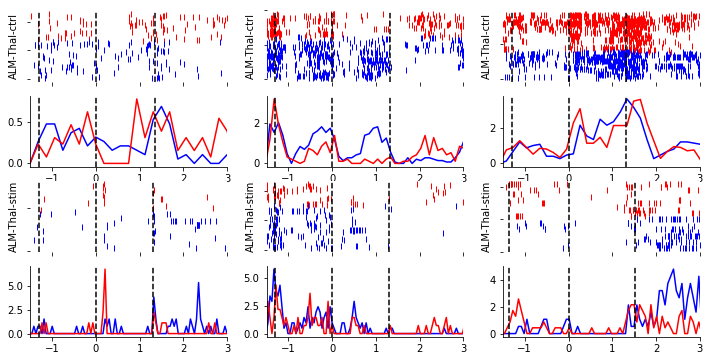

In [21]:
fig3 = plt.figure(figsize=(12, 6))

ax_11t = fig3.add_subplot(4, 3, 1)
ax_11b = fig3.add_subplot(4, 3, 4)
plot_spike_raster_and_histogram(alm_insert_thal_stim_unit_1['contra_ctrl'], alm_insert_thal_stim_unit_1['ipsi_ctrl'], 
                                axes = (ax_11t, ax_11b), ax_title='ALM-Thal-ctrl', bin_counts=200)
ax_21t = fig3.add_subplot(4, 3, 7)
ax_21b = fig3.add_subplot(4, 3, 10)
plot_spike_raster_and_histogram(alm_insert_thal_stim_unit_1['contra_stim'], alm_insert_thal_stim_unit_1['ipsi_stim'], 
                                axes = (ax_21t, ax_21b), ax_title='ALM-Thal-stim', bin_counts=200)

ax_12t = fig3.add_subplot(4, 3, 2)
ax_12b = fig3.add_subplot(4, 3, 5)
plot_spike_raster_and_histogram(alm_insert_thal_stim_unit_2['contra_ctrl'], alm_insert_thal_stim_unit_2['ipsi_ctrl'], 
                                axes = (ax_12t, ax_12b), ax_title='ALM-Thal-ctrl', bin_counts=200)
ax_22t = fig3.add_subplot(4, 3, 8)
ax_22b = fig3.add_subplot(4, 3, 11)
plot_spike_raster_and_histogram(alm_insert_thal_stim_unit_2['contra_stim'], alm_insert_thal_stim_unit_2['ipsi_stim'], 
                                axes = (ax_22t, ax_22b), ax_title='ALM-Thal-stim', bin_counts=200)

ax_13t = fig3.add_subplot(4, 3, 3)
ax_13b = fig3.add_subplot(4, 3, 6)
plot_spike_raster_and_histogram(alm_insert_thal_stim_unit_3['contra_ctrl'], alm_insert_thal_stim_unit_3['ipsi_ctrl'], 
                                axes = (ax_13t, ax_13b), ax_title='ALM-Thal-ctrl', bin_counts=200)
ax_23t = fig3.add_subplot(4, 3, 9)
ax_23b = fig3.add_subplot(4, 3, 12)
plot_spike_raster_and_histogram(alm_insert_thal_stim_unit_3['contra_stim'], alm_insert_thal_stim_unit_3['ipsi_stim'], 
                                axes = (ax_23t, ax_23b), ax_title='ALM-Thal-stim', bin_counts=200)

In [22]:
# # Chery-picking unit and session...
# for idx, sess in enumerate(thal_insert_alm_stim.fetch('KEY')): # pick one session here
#     print([idx, len(acquisition.TrialSet.Trial & sess & correct_contra_trial_stim),
#            len(acquisition.TrialSet.Trial & sess & correct_ipsi_trial_stim)])

In [23]:
# 3 units with Thalmus insert and ALM photostim
thal_insert_alm_stim_unit_1 = make_unit_spiketimes(unit=1, sess=thal_insert_alm_stim.fetch('KEY')[1])
thal_insert_alm_stim_unit_2 = make_unit_spiketimes(unit=1, sess=thal_insert_alm_stim.fetch('KEY')[2])
thal_insert_alm_stim_unit_3 = make_unit_spiketimes(unit=1, sess=thal_insert_alm_stim.fetch('KEY')[35])

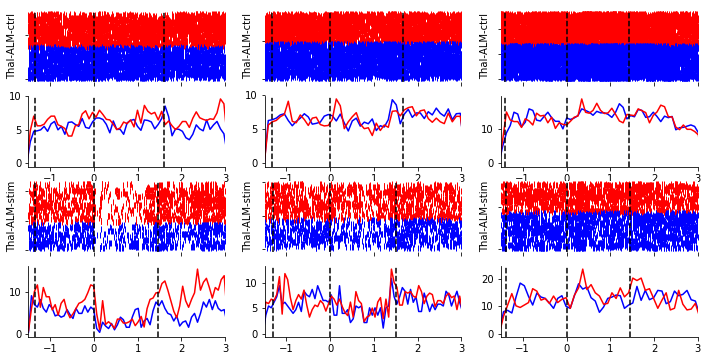

In [24]:
fig3 = plt.figure(figsize=(12, 6))

ax_11t = fig3.add_subplot(4, 3, 1)
ax_11b = fig3.add_subplot(4, 3, 4)
plot_spike_raster_and_histogram(thal_insert_alm_stim_unit_1['contra_ctrl'], thal_insert_alm_stim_unit_1['ipsi_ctrl'], 
                                axes = (ax_11t, ax_11b), ax_title='Thal-ALM-ctrl', bin_counts=200)
ax_21t = fig3.add_subplot(4, 3, 7)
ax_21b = fig3.add_subplot(4, 3, 10)
plot_spike_raster_and_histogram(thal_insert_alm_stim_unit_1['contra_stim'], thal_insert_alm_stim_unit_1['ipsi_stim'], 
                                axes = (ax_21t, ax_21b), ax_title='Thal-ALM-stim', bin_counts=200)

ax_12t = fig3.add_subplot(4, 3, 2)
ax_12b = fig3.add_subplot(4, 3, 5)
plot_spike_raster_and_histogram(thal_insert_alm_stim_unit_2['contra_ctrl'], thal_insert_alm_stim_unit_2['ipsi_ctrl'], 
                                axes = (ax_12t, ax_12b), ax_title='Thal-ALM-ctrl', bin_counts=200)
ax_22t = fig3.add_subplot(4, 3, 8)
ax_22b = fig3.add_subplot(4, 3, 11)
plot_spike_raster_and_histogram(thal_insert_alm_stim_unit_2['contra_stim'], thal_insert_alm_stim_unit_2['ipsi_stim'], 
                                axes = (ax_22t, ax_22b), ax_title='Thal-ALM-stim', bin_counts=200)

ax_13t = fig3.add_subplot(4, 3, 3)
ax_13b = fig3.add_subplot(4, 3, 6)
plot_spike_raster_and_histogram(thal_insert_alm_stim_unit_3['contra_ctrl'], thal_insert_alm_stim_unit_3['ipsi_ctrl'], 
                                axes = (ax_13t, ax_13b), ax_title='Thal-ALM-ctrl', bin_counts=200)
ax_23t = fig3.add_subplot(4, 3, 9)
ax_23b = fig3.add_subplot(4, 3, 12)
plot_spike_raster_and_histogram(thal_insert_alm_stim_unit_3['contra_stim'], thal_insert_alm_stim_unit_3['ipsi_stim'], 
                                axes = (ax_23t, ax_23b), ax_title='Thal-ALM-stim', bin_counts=200)

# Population - Fig 3e and 6e

In [25]:
# get trial-segmented spiketimes for all units in all specifed sessions
def query_all_segmented_spiketimes(sess_key, trial_key, seg_param_key):
    data_keys = (analysis.TrialSegmentedUnitSpikeTimes & sess_key & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key)).fetch(dj.key)
    data = []
    for k in data_keys:
        segmented_spike_times = (analysis.TrialSegmentedUnitSpikeTimes & k).fetch1('segmented_spike_times') 
        
        contra_spk_counts, contra_edges = np.histogram(np.hstack([r for r in red_spike_times.segmented_spike_times]),
                                   bins=bin_counts,
                                   range=(timestamps[0], timestamps[-1]))
        contra_spk_rates = contra_spk_counts / np.diff(contra_edges)
    
        realigned_trial_event, realigned_event_time = (analysis.RealignedEvent.RealignedEventTime & k).fetch('realigned_trial_event','realigned_event_time')
        data.append({
                **{'segmented_spike_times': segmented_spike_times}, 
                **dict(zip(realigned_trial_event, realigned_event_time))}) 
    return pd.DataFrame(data)

In [26]:
# get trial-segmented spiketimes for all units in all specifed sessions
def extract_segmented_spiketimes_histogram(sess_key, trial_key, seg_param_key, time_range=(-1.5, 3), bin_counts=100):
    data_keys = (analysis.TrialSegmentedUnitSpikeTimes & sess_key & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key)).fetch(dj.key)
    print(f'Found {len(data_keys)} total trials')
    data = []
    for idx, k in enumerate(data_keys):
        segmented_spike_times = (analysis.TrialSegmentedUnitSpikeTimes & k).fetch1('segmented_spike_times')
        segmented_spike_times = segmented_spike_times[(segmented_spike_times >= time_range[0]) & (segmented_spike_times <= time_range[-1])]

        spk_counts, spk_edges = np.histogram(segmented_spike_times, bins=bin_counts, range=time_range)
        data.append(spk_counts / np.diff(spk_edges))
    return {'data': np.vstack(data), 'timestamps': spk_edges[1:]}

In [27]:
# get segmented spike times for population - ALM/thal-insert, thal-stim
stim_trial =  {'trial_is_good': True, 'trial_stim_present': True}
ctrl_trial =  {'trial_is_good': True, 'trial_stim_present': False}

In [28]:
# ALM insert, Thalamus stimulation
alm_insert_thal_stim_ctrl = extract_segmented_spiketimes_histogram(alm_insert_thal_stim, ctrl_trial, seg_param_key,
                                                                   (-0.2, 0.5), 200)
alm_insert_thal_stim_stim = extract_segmented_spiketimes_histogram(alm_insert_thal_stim, stim_trial, seg_param_key,
                                                                   (-0.2, 0.5), 200)

Found 134557 total trials
Found 37384 total trials


In [ ]:
# Thalamus insert, Thalamus stimulation
thal_insert_thal_stim_ctrl = extract_segmented_spiketimes_histogram(thal_insert_thal_stim, ctrl_trial, seg_param_key,
                                                                    (-0.2, 0.5), 200)
thal_insert_thal_stim_stim = extract_segmented_spiketimes_histogram(thal_insert_thal_stim, stim_trial, seg_param_key,
                                                                    (-0.2, 0.5), 200)

In [ ]:
# ALM insert, ALM stimulation
alm_insert_alm_stim_ctrl = extract_segmented_spiketimes_histogram(alm_insert_alm_stim, ctrl_trial, seg_param_key,
                                                                   (-0.2, 0.5), 200)
alm_insert_alm_stim_stim = extract_segmented_spiketimes_histogram(alm_insert_alm_stim, stim_trial, seg_param_key,
                                                                   (-0.2, 0.5), 200)

In [ ]:
# Thalamus insert, ALM stimulation
thal_insert_alm_stim_ctrl = extract_segmented_spiketimes_histogram(thal_insert_alm_stim, ctrl_trial, seg_param_key,
                                                                    (-0.2, 0.5), 200)
thal_insert_alm_stim_stim = extract_segmented_spiketimes_histogram(thal_insert_alm_stim, stim_trial, seg_param_key,
                                                                    (-0.2, 0.5), 200)

In [ ]:
fig36 = plt.figure(figsize=(6, 6))
fig36.subplots_adjust(hspace=0.3)

ax_3e1 = fig36.add_subplot(221)
plot_with_sem(alm_insert_thal_stim_stim, alm_insert_thal_stim_ctrl, ax_3e1)
ax_3e1.set_xlim(-0.02, 0.04);
ax_3e1.set_title('ALM-insert, Thal-stim')

ax_3e2 = fig36.add_subplot(222)
plot_with_sem(thal_insert_thal_stim_stim, thal_insert_thal_stim_ctrl, ax_3e2)
ax_3e2.set_xlim(-0.02, 0.04);
ax_3e2.set_title('Thal-insert, Thal-stim')

ax_6e1 = fig36.add_subplot(223)
plot_with_sem(alm_insert_alm_stim_stim, alm_insert_alm_stim_ctrl, ax_6e1)
ax_6e1.set_xlim(-0.02, 0.04);
ax_6e1.set_title('ALM-insert, ALM-stim')

ax_6e2 = fig36.add_subplot(224)
plot_with_sem(thal_insert_alm_stim_stim, thal_insert_alm_stim_ctrl, ax_6e2)
ax_6e2.set_xlim(-0.02, 0.04);
ax_6e2.set_title('Thal-insert, ALM-stim')